In [1]:
# prologue

# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.routines as rt

# common config - can be ommitted
project_dir = 'V:\\whiteboxing'
random_state_splits = 123 # for splitting the data into test / train
random_state = 123 # for everything else - you might want to build a new rf with same data
n_instances = 10000 # how many instances to explain in total from the test set, high setting will complete the test set

# control for memory intensive process - how many instances to explain at a time from the test set
batch_size = 5 # make this smaller for a less powerful machine, high setting will complete the test set in one run

# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
chirps_explanation_async=False

In [2]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
mydata = ds.cardio_data(random_state=random_state, project_dir=project_dir)

# split the data. here using a basic sampling method.
# the returned object is a dictionary containing:
# the train and test splits for X and y
# also the the encoded version of X_train and the encoder function
# also some meta-data: priors for y, the indexes from the input data

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build a random forest, tuned for high accuracy

################ PARAMETER TUNING ###################
############ Only runs when required ################
#####################################################

best_params = rt.tune_rf(
 X=tt.X_train_enc,
 y=tt.y_train,
 save_path = mydata.make_save_path(), # override_tuning=False, # default
 random_state=mydata.random_state) 

#####################################################

# train a rf model. there are two outputs. both are models for prediction
# according to best practice, categorical variables are first onehot encoded
# because if you leave the integer encoded values, scikit treats nominal as ordinal
# so the first return value is the bare model output by scikit which simply predicts
# and the second is a pipeline which first performs the above encoding, then predicts
# piplines are for convenience, so it is easy to predict from the original dataset
rf = rt.train_rf(
 X=tt.X_train_enc,
 y=tt.y_train,
 best_params=best_params,
 random_state=mydata.random_state)

using previous tuning parameters


Confusion matrix, without normalization
[[483   3  10]
 [  6  48   3]
 [ 19   2  64]]


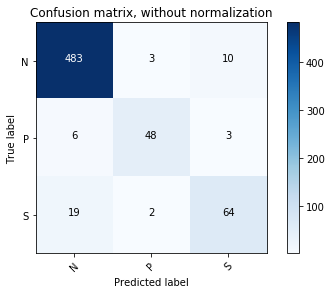

Normalized confusion matrix
[[0.97 0.01 0.02]
 [0.11 0.84 0.05]
 [0.22 0.02 0.75]]


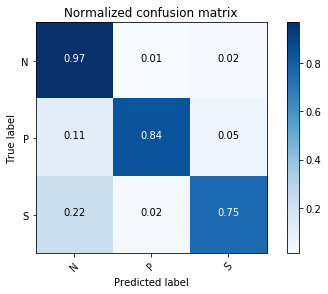

In [3]:
# evaluate the model and plot a confusion matrix
# the outputs of this function are:
# cm - confusion matrix as 2d array
# acc - accuracy of model = correctly classified instance / total number instances
# coka - Cohen's kappa score. Accuracy adjusted for probability of correct by random guess. Useful for multiclass problems
# prfs - precision, recall, f-score, support with the following signatures as a 2d array
# 0 <= p, r, f <= 1. s = number of instances for each true class label (row sums of cm)
cm, acc, coka, prfs = rt.evaluate_model(prediction_model=rf, X=tt.X_test_enc, y=tt.y_test,
             class_names=mydata.get_label(mydata.class_col, [i for i in range(len(mydata.class_names))]).tolist(),
             plot_cm=True, plot_cm_norm=True)

In [4]:
# optional step - to control how many instance CHIRPS processes in one go:
# CHIRPS is time economical but memory intensive to compute for lots of instances at once
# the number of instances can be controlled from the n_instances and batch_size settings at the top
# the following will set things up to process the whole test set
n_instances = min(n_instances, len(tt.y_test))
batch_size = min(batch_size, len(tt.y_test))
n_batches = int(batch_size / n_instances) 
n_instances, n_batches

# this gets the next batch out of the batch_getter (whole test set with the current settings)
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
instances, instances_enc, instances_enc_matrix, labels = tt.get_next(batch_size, which_split='train') # default

# alternatively, just run this line for the whole test set
# instances = tt.X_train; instances_enc = tt.X_train_enc; instances_enc_matrix = tt.X_train_enc_matrix; labels = tt.y_train

In [13]:
# CHIRPS step 1 uses rf prediction to walk each tree and generate a path per tree per instance
# to facilitate this we have a wrapper object for the rf and the data container that gets all the structure
kwargs = mydata.get_meta()

f_walker = strcts.forest_walker(forest = rf, **kwargs)

In [6]:
# here the work of extracting all the paths for each instance is done
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - returns a batch_paths_container
# requires the X instances in a matrix (dense, ordinary np) - this is available in the data_split_container
bp_container = f_walker.forest_walk(instances = instances_enc_matrix
                        , labels = labels
                        , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')
print('Forest Walk with async = ' + str(forest_walk_async))

Walking forest for 5 instances... (please wait)
Forest Walk time elapsed: 1.6089 seconds
Forest Walk with async = True


In [7]:
# build CHIRPS and a rule for each instance represented in the batch paths container
CHIRPS = strcts.batch_CHIRPS_container(bp_container,
                                data_container=mydata,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                sample_labels=tt.y_train  # any representative sample can be used
                                )
print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.build_CHIRPS(chirps_explanation_async=chirps_explanation_async) # all the defaults

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

CHIRPS.CHIRPS_containers

Running CHIRPS on a batch of 5 instances... (please wait)


C:\Users\id126493\Documents\GitHub\explain_te\CHIRPS\structures.py:354: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\explain_te\CHIRPS\structures.py:358: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


CHIRPS time elapsed: 1.2412 seconds
CHIRPS with async = False


In [8]:
# important point:
# test set has never been "seen" by random forest during training
# test set has been used to assess model (random forest) accuracy - no additional tuning after this

# test set has been used to create an explainer *one instance at a time*
# rest of test set was not "seen" during construction of each explainer

# to score each explainer, we use test set, leaving out the individual instance being explained
# the data_split_container has a convenience funtion for this

# get all the model predictions
pred_instances = tt.X_test_enc
pred_indices = tt.y_test.index
pred_labels = rf.predict(X=pred_instances)


In [9]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
results_start_time = timeit.default_timer()

headers = ['instance_id', 'result_set',
                'pretty rule', 'rule length',
                'pred class', 'pred class label',
                'target class', 'target class label',
                'majority voting trees', 'majority vote share', 'pred prior',
                'precision(tr)', 'recall(tr)', 'f1(tr)',
                'accuracy(tr)', 'lift(tr)',
                'total coverage(tr)',
                'precision(tt)', 'recall(tt)', 'f1(tt)',
                'accuracy(tt)', 'lift(tt)',
                'total coverage(tt)', 'model_acc', 'model_ck']
output = [[]] * len(CHIRPS.CHIRPS_containers)

for i, c in enumerate(CHIRPS.CHIRPS_containers):
    
    # instance meta data
    instance_id = pred_indices[i]
    mc = c.major_class
    mc_lab = c.major_class_label
    tc = c.target_class
    tc_lab = c.target_class_label
    vt = c.model_votes['counts'][tc]
    mvs = c.model_posterior[tc]
    prior = c.posterior[0][tc]
    rule = c.pruned_rule
    pretty_rule = c.prettify_rule()
    rule_len = len(rule)
    # final metrics from rule merge step (usually based on training set)
    tr_prec = list(reversed(c.posterior))[tc]
    tr_recall = list(reversed(c.recall))[tc]
    tr_f1 = list(reversed(c.f1))[tc]
    tr_acc = list(reversed(c.accuracy))[tc]
    tr_lift = list(reversed(c.lift))[tc]
    tr_coverage = list(reversed(c.coverage))
    
#     # get test sample by leave-one-out on current instance
    instances, enc_instances, labels = tt.get_loo_instances(instance_id)
#     rt = strcts.rule_tester(data_container=mydata, rule=rule,
#                         sample_instances=enc_instances,
#                         sample_labels=labels)
    # then evaluating rule metrics on test set
#     eval_rule = rt.evaluate_rule()
#     print(eval_rule)
    # collect results
#     tt_prec = eval_rule['post'][tc]
#     tt_recall = eval_rule['recall'][tc]
#     tt_f1 = eval_rule['f1'][tc]
#     tt_acc = eval_rule['accuracy'][tc]
#     tt_lift = eval_rule['lift'][tc]
#     tt_coverage = eval_rule['coverage']

evaluating found explanations


In [10]:
c.prettify_rule()

'ASTV <= 59.73205 AND Mean > 107.80275 AND DP <= 0.0014 AND Median <= 151.35294'

In [11]:

for i in range(len(explainers)):
    for j, rs in enumerate(result_sets):
        




        output[j * len(explainers) + i] = [instance_id,
                rs,
                pretty_rule,
                rule_len,
                mc,
                mc_lab,
                tc,
                tc_lab,
                vt,
                mvs,
                prior,
                tr_prec,
                tr_recall,
                tr_f1,
                tr_acc,
                tr_lift,
                tr_coverage,
                tt_prec,
                tt_recall,
                tt_f1,
                tt_acc,
                tt_lift,
                tt_coverage,
                acc,
                coka]

wbres_end_time = timeit.default_timer()
wbres_elapsed_time = wbres_end_time - wbres_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(wbres_elapsed_time), 'seconds')
# this completes the CHIRPS runs

NameError: name 'explainers' is not defined